# How to split train/test periods 

In [138]:
# !pip install netcdf4

In [139]:
# !conda install -c conda-forge shap==0.30

In [140]:
# !conda update matplotlib

In [141]:
from pathlib import Path
import os
import warnings
from typing import Tuple, Optional, Union, Dict, List

%load_ext autoreload
%autoreload

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jovyan/ml_drought


In [142]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

data_dir = Path('data/')

assert data_dir.exists()

In [143]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.utils import get_ds_mask

In [144]:
TRUE_EXPERIMENT = 'one_month_forecast_boku_VCI'
TARGET_VAR =      'boku_VCI'

# EXPERIMENT =      'one_month_forecast_BOKU_boku_VCI_our_vars'
experiment_names = ['ar', 'ar_dynamic', 'ar_dynamic_static']

experiments = [
    "2020_02_17:122024_one_month_forecast_boku_VCI_NOstatic_boku_VCI",
    "2020_02_17:123014_one_month_forecast_boku_VCI_precip_t2m_pet_E_SMroot_SMsurf_NOstatic_boku_VCI",
    "2020_02_17:123856_one_month_forecast_boku_VCI_precip_t2m_pet_E_SMroot_SMsurf_YESstatic_boku_VCI",
]

# Read in the data

In [145]:
X_train, y_train = read_train_data(data_dir, experiment=TRUE_EXPERIMENT)
X_test, y_test = read_test_data(data_dir, experiment=TRUE_EXPERIMENT)
static_ds = xr.open_dataset(data_dir / "features/static/data.nc")

ds = xr.merge([y_train, y_test]).sortby('time').sortby('lat')
d_ = xr.merge([X_train, X_test]).sortby('time').sortby('lat')
ds = xr.merge([ds, d_])

In [146]:
if not (data_dir / 'tommy/ds.nc').exists():
    ds.to_netcdf(data_dir / 'tommy/ds.nc')
    static_ds.to_netcdf(data_dir / 'tommy/static_ds.nc')
    X_train.to_netcdf(data_dir / 'tommy/X_train.nc')
    y_train.to_netcdf(data_dir / 'tommy/y_train.nc')
    X_test.to_netcdf(data_dir / 'tommy/X_test.nc')
    y_test.to_netcdf(data_dir / 'tommy/y_test.nc')

In [147]:
print("TRAINING DATA")
display(ds)
print('\n\n')
print("TARGET DATA")
display(y_test)

TRAINING DATA


<xarray.Dataset>
Dimensions:     (lat: 45, lon: 35, time: 205)
Coordinates:
  * time        (time) datetime64[ns] 2001-12-31 2002-01-31 ... 2018-12-31
  * lat         (lat) float32 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.25 5.5 5.75 6.0
  * lon         (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
Data variables:
    boku_VCI    (time, lat, lon) float64 100.0 100.0 98.82 ... 11.94 78.34 40.51
    VCI3M       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    modis_ndvi  (time, lat, lon) float64 0.688 0.5456 0.7328 ... nan nan nan
    VCI         (time, lat, lon) float64 57.69 89.55 63.82 45.12 ... nan nan nan
    precip      (time, lat, lon) float64 102.0 107.6 122.3 111.1 ... nan nan nan
    E           (time, lat, lon) float64 85.9 60.61 60.61 57.43 ... nan nan nan
    Eb          (time, lat, lon) float64 3.518 1.266 1.266 2.995 ... nan nan nan
    SMroot      (time, lat, lon) float64 0.2638 0.2245 0.2245 ... nan nan nan
    SMsurf      (time, lat, lon) float64 0.2978 0.2648 0.2648 ... nan nan nan
    p84.162     (time, lat, lon) float64 1.45e-05 -5.456e-05 ... nan nan
    pev         (time, lat, lon) float64 -0.005993 -0.006077 ... nan nan
    sp          (time, lat, lon) float64 8.862e+04 8.927e+04 ... nan nan
    t2m         (time, lat, lon) float64 297.5 298.4 297.4 296.2 ... nan nan nan
    tp          (time, lat, lon) float64 0.003657 0.00285 0.004386 ... nan nan




TARGET DATA


<xarray.Dataset>
Dimensions:   (lat: 45, lon: 35, time: 36)
Coordinates:
  * lat       (lat) float32 6.0 5.75 5.5 5.25 5.0 ... -4.0 -4.25 -4.5 -4.75 -5.0
  * lon       (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
  * time      (time) datetime64[ns] 2016-01-31 2016-02-29 ... 2018-12-31
Data variables:
    boku_VCI  (time, lat, lon) float64 64.45 52.16 97.37 96.48 ... nan nan nan

# How many months in the data?

In [148]:
print("N Months: ".ljust(25), ds.time.shape[0])
print("Years: ".ljust(25), ds.time.min().values, ds.time.max().values)

N Months:                 205
Years:                    2001-12-31T00:00:00.000000000 2018-12-31T00:00:00.000000000


In [149]:
print("After accounting for 3 month inputs")
print("N Months: ".ljust(25), xr.auto_combine([y_train, y_test]).time.shape[0])
print("Years: ".ljust(25), xr.auto_combine([y_train, y_test]).time.min().values, xr.auto_combine([y_train, y_test]).time.max().values)

After accounting for 3 month inputs
N Months:                 202
Years:                    2002-03-31T00:00:00.000000000 2018-12-31T00:00:00.000000000


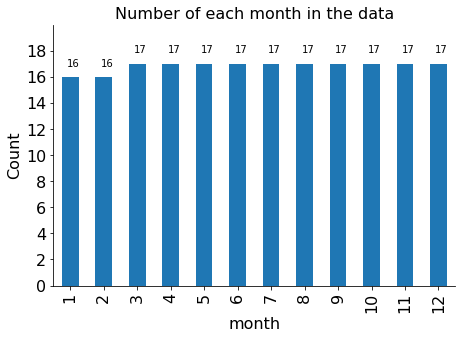

In [150]:
# How many of each month?
scale = 0.6
fig, ax = plt.subplots(figsize=(12*scale, 8*scale))
(
    xr.auto_combine([y_train, y_test])
    .groupby('time.month')
    .count().max(dim=['lat', 'lon'])
    .to_dataframe().plot.bar(ax=ax, legend=False)
)

ax.set_ylim(0, 20)
ax.set_title('Number of each month in the data')
ax.set_ylabel('Count')
ax.set_yticks([i for i in range(0, 20)][::2])
ax.set_yticklabels([i for i in range(0, 20)][::2])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.0f}",  # annotation (str)
        (p.get_x() + (p.get_width() / 3.2), p.get_height() * 1.05),  # (x, y) coords
    )

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] 
             + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

In [151]:
import calendar

def make_monthly_calendar_plot(df, ax, title, **kwargs):
    assert 'year' in [c for c in df.columns]
    assert 'month' in [c for c in df.columns]
    im = ax.imshow(df.pivot(index='year', columns='month').values, aspect='auto', **kwargs)

    ax.set_xticks([i for i in range(0, 12)])
    ax.set_xticklabels([calendar.month_abbr[i+1] for i in range(0, 12)]);
    ax.set_xlabel('Month')
    plt.xticks(rotation=45)

    ax.set_yticks([i for i in range(len(df.year.unique()))])
    ax.set_yticklabels([yr for yr in range(df.year.min(), df.year.max() + 1)]);
    ax.set_ylabel('Year')
    
    ax.set_title(title)

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] 
                 + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)

    cbar = fig.colorbar(im);
    cbar.set_label(
        [c for c in df.columns if c not in ['year', 'month']][0],
        fontsize=14
    )
    
    return ax

,boku_VCI,month,year
2001-01-31,False,1,2001
2001-02-28,False,2,2001
2001-03-31,False,3,2001
2001-04-30,False,4,2001
2001-05-31,False,5,2001


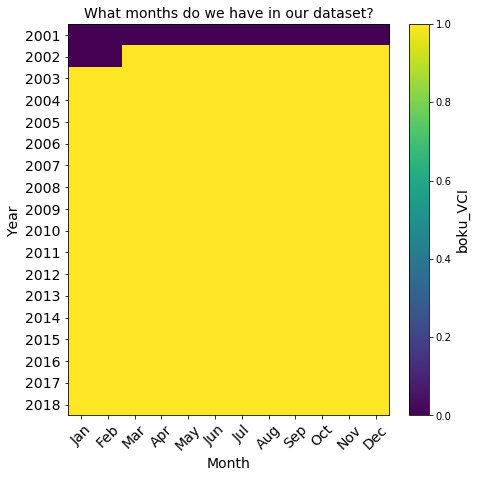

In [152]:
import calendar
import matplotlib as mpl

scale = 0.6
fig, ax = plt.subplots(figsize=(12*scale, 12*scale))

demo_df = (xr.auto_combine([y_train, y_test]).isnull().mean(dim=['lat', 'lon']) < 0.9).to_dataframe()
non_dates = pd.date_range('2001-01-01', '2002-03-14', freq='M')
non_date_values = [False for _ in range(len(non_dates))]

demo_df = pd.concat([pd.DataFrame({'boku_VCI': non_date_values}, index=non_dates), demo_df])

demo_df['month'] = demo_df.index.month
demo_df['year'] = demo_df.index.year

display(demo_df.head())

# MAKE PLOT
title = 'What months do we have in our dataset?'
make_monthly_calendar_plot(demo_df.astype(int), ax=ax, title=title)

### What are the distribution of the months by boku_VCI?

In [153]:
y_ds = xr.auto_combine([y_train, y_test])

y_ds

<xarray.Dataset>
Dimensions:   (lat: 45, lon: 35, time: 202)
Coordinates:
  * lat       (lat) float32 6.0 5.75 5.5 5.25 5.0 ... -4.0 -4.25 -4.5 -4.75 -5.0
  * lon       (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
  * time      (time) datetime64[ns] 2002-03-31 2002-04-30 ... 2018-12-31
Data variables:
    boku_VCI  (time, lat, lon) float64 50.0 34.07 23.6 44.72 ... nan nan nan nan

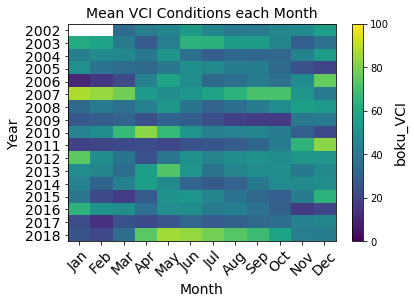

In [154]:
df = y_ds.mean(dim=['lat', 'lon']).to_dataframe()
df['year'] = df.index.year
df['month'] = df.index.month
kwargs = dict(vmin=0, vmax=100)

fig, ax = plt.subplots()
title = 'Mean VCI Conditions each Month'
ax = make_monthly_calendar_plot(df, ax, title=title, **kwargs)

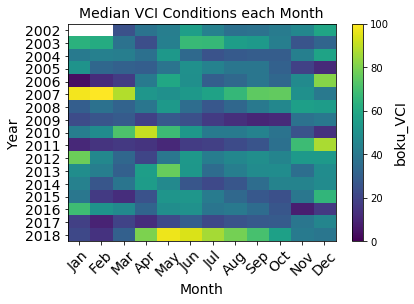

In [155]:
df = y_ds.median(dim=['lat', 'lon']).to_dataframe()
df['year'] = df.index.year
df['month'] = df.index.month
kwargs = dict(vmin=0, vmax=100)

fig, ax = plt.subplots()
title = 'Median VCI Conditions each Month'
ax = make_monthly_calendar_plot(df, ax, title=title, **kwargs)

### What does the raw NDVI look like?

In [156]:
# Read the target data
if TARGET_VAR == 'VCI':
    target_data = xr.open_dataset(
        data_dir / "interim" / "VCI_preprocessed" / "data_kenya.nc"
    )

if TARGET_VAR == 'boku_VCI':
    target_data = xr.open_dataset(
        data_dir / "interim" / "boku_ndvi_1000_preprocessed" / "data_kenya.nc"
    )

target_data[TARGET_VAR]

<xarray.DataArray 'boku_VCI' (time: 216, lat: 45, lon: 35)>
[340200 values with dtype=float64]
Coordinates:
  * lat      (lat) float32 6.0 5.75 5.5 5.25 5.0 ... -4.0 -4.25 -4.5 -4.75 -5.0
  * time     (time) datetime64[ns] 2001-12-31 2002-01-31 ... 2019-11-30
  * lon      (lon) float32 33.75 34.0 34.25 34.5 34.75 ... 41.5 41.75 42.0 42.25

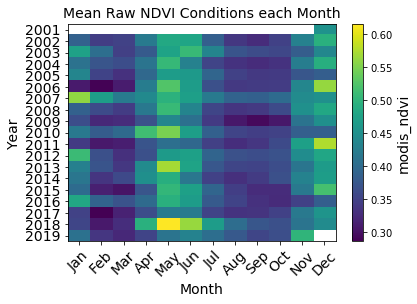

In [157]:
df = target_data['modis_ndvi'].mean(dim=['lat', 'lon']).to_dataframe()
df['year'] = df.index.year
df['month'] = df.index.month

fig, ax = plt.subplots()
title = 'Mean Raw NDVI Conditions each Month'
ax = make_monthly_calendar_plot(df, ax, title=title)

### How to split the data each month into different groups?

# TODO-> Need to figure out how to accomodate the fact that ONLY AFTER ENGINEER calculated can we know which timesteps have been kept in the data

In [158]:
from src.engineer import Engineer

# dir(Engineer(data_dir).engineer_class) # ._get_preprocessed_files(static=False)

target_data = Engineer(data_dir).engineer_class._make_dataset(static=False)
median_data = target_data.resample(time='M').mean().median(dim=['lat', 'lon'])
median_data = median_data.to_dataframe()
median_data.head()

Processing data/interim/boku_ndvi_1000_preprocessed/data_kenya.nc
Processing data/interim/VCI_preprocessed/data_kenya.nc
Processing data/interim/chirps_preprocessed/data_kenya.nc
Processing data/interim/gleam_preprocessed/data_kenya.nc
Processing data/interim/reanalysis-era5-single-levels-monthly-means_preprocessed/data_kenya.nc


,VCI3M,boku_VCI,modis_ndvi,VCI,precip,E,Eb,SMroot,SMsurf,p84.162,pev,sp,t2m,tp
time,,,,,,,,,,,,,,
2001-12-31,NaN,43.055556,0.4560,32.057499,21.859242,45.608809,2.965797,0.201504,0.207303,0.000014,-0.005765,93200.312500,299.315887,0.000807
2002-01-31,NaN,30.769231,0.3520,26.610000,14.795188,35.431196,2.037934,0.186523,0.187518,0.000004,-0.006143,93141.179688,299.754852,0.000812
2002-02-28,32.469614,25.641026,0.2912,28.387499,6.609784,16.215282,0.666768,0.177030,0.161835,0.000003,-0.007161,93144.921875,299.903168,0.000126
2002-03-31,29.103423,24.675325,0.2896,29.700000,72.697720,51.606473,4.366209,0.187409,0.215969,-0.000002,-0.005916,93082.039062,300.407074,0.002086
2002-04-30,31.255909,38.271605,0.3968,36.306000,127.766075,61.923396,7.966903,0.215586,0.265866,-0.000021,-0.005089,93069.132812,299.127380,0.004093


In [159]:
pred_months = 3
median_data.iloc[3+1:]

,VCI3M,boku_VCI,modis_ndvi,VCI,precip,E,Eb,SMroot,SMsurf,p84.162,pev,sp,t2m,tp
time,,,,,,,,,,,,,,
2002-04-30,31.255909,38.271605,0.3968,36.306000,127.766075,61.923396,7.966903,0.215586,0.265866,-2.087859e-05,-0.005089,93069.132812,299.127380,0.004093
2002-05-31,37.948630,42.803030,0.4768,46.332500,61.683664,72.008170,6.806247,0.258991,0.266277,2.035145e-05,-0.005210,93264.031250,298.532349,0.001811
2002-06-30,46.406146,56.140351,0.4784,47.927499,8.227008,39.243689,1.120369,0.222572,0.213591,1.071281e-05,-0.005259,93406.867188,298.055725,0.000297
2002-07-31,48.715509,44.036697,0.3488,52.212000,8.691737,25.626426,0.480253,0.197670,0.186912,1.500046e-05,-0.005702,93451.429688,297.940979,0.000169
2002-08-31,45.824868,36.781609,0.2928,50.457499,7.607576,16.367387,0.336308,0.184162,0.178619,8.328880e-06,-0.005699,93408.953125,297.703430,0.000264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31,84.185981,78.947368,0.3600,59.329999,9.859747,31.165103,0.752710,0.213881,0.194055,7.608556e-06,-0.005655,93436.015625,297.948364,0.000302
2018-09-30,77.874889,70.759112,0.3232,55.342498,12.455189,24.776881,1.199238,0.195890,0.178368,1.129594e-05,-0.006408,93282.351562,298.365601,0.000398
2018-10-31,68.141439,56.936297,0.3216,44.348999,48.118713,31.623228,4.016439,0.190586,0.193646,-5.082886e-06,-0.005879,93266.945312,298.944031,0.001624


In [160]:
def get_valid_test_timesteps(pred_timesteps: int, target_data: pd.DataFrame) -> pd.DataFrame:
    """Need at least `pred_timesteps + 1` before the test timestep to 
    allow enough previous timesteps of predictor variables!
    """
    return target_data.iloc[pred_timesteps + 1:, :]
    

# SORT BY MEDIAN VCI EACH MONTH (over space)
def sort_by_median_target_var(pred_timesteps: int, data_dir: Path = Path('data')) -> Tuple[pd.DataFrame, pd.DatetimeIndex]:
    """ Calculate the sorted_timesteps to then calculate hi/med/lo 
    train and test periods.
    """
    target_data = Engineer(data_dir).engineer_class._make_dataset(static=False)
    
    target_variable = [v for v in target_data.data_vars][0]

    median_data = target_data.resample(time='M').mean().median(dim=['lat', 'lon'])
    median_data = median_data.to_dataframe()
    median_data = get_valid_test_timesteps(
        pred_timesteps=pred_timesteps,
        target_data=median_data,
    )

    # sorted low to high
    sorted_df = median_data.sort_values(target_variable)
    sorted_timesteps = sorted_df.index

    return sorted_df, sorted_timesteps

# target_data: xr.DataArray
sorted_df, sorted_timesteps = sort_by_median_target_var(pred_timesteps=3)

Processing data/interim/boku_ndvi_1000_preprocessed/data_kenya.nc
Processing data/interim/VCI_preprocessed/data_kenya.nc
Processing data/interim/chirps_preprocessed/data_kenya.nc
Processing data/interim/gleam_preprocessed/data_kenya.nc
Processing data/interim/reanalysis-era5-single-levels-monthly-means_preprocessed/data_kenya.nc


In [161]:
pred_months=3
target_data.isel(time=slice(pred_months, -1))

<xarray.Dataset>
Dimensions:     (lat: 45, lon: 35, time: 201)
Coordinates:
  * time        (time) datetime64[ns] 2002-03-31 2002-04-30 ... 2018-11-30
  * lat         (lat) float32 6.0 5.75 5.5 5.25 5.0 ... -4.25 -4.5 -4.75 -5.0
  * lon         (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
Data variables:
    VCI3M       (time, lat, lon) float64 ...
    boku_VCI    (time, lat, lon) float64 ...
    modis_ndvi  (time, lat, lon) float64 ...
    VCI         (time, lat, lon) float64 ...
    precip      (time, lat, lon) float64 ...
    E           (time, lat, lon) float64 ...
    Eb          (time, lat, lon) float64 ...
    SMroot      (time, lat, lon) float64 ...
    SMsurf      (time, lat, lon) float64 ...
    p84.162     (time, lat, lon) float64 ...
    pev         (time, lat, lon) float64 ...
    sp          (time, lat, lon) float64 ...
    t2m         (time, lat, lon) float64 ...
    tp          (time, lat, lon) float64 ...

In [162]:
# calculate how many months in each group -> List[int, int, int]
from typing import List

def calculate_length_of_hi_med_lo_experiment_train_years(
    total_months: int, 
    test_length: int = 12,
    pred_timesteps: int = 3,
) -> List[int]:
    # how many months do we have for train/test
    total_train_months = total_months - (test_length * (pred_timesteps + 1))
    
    # split into 3 groups
    # round up the group sizes
    train_length_1 = train_length_2 = round(total_train_months / 3)
    train_length_0 = round(total_train_months / 3)

    if not train_length_0 + train_length_1 + train_length_2 == total_train_months:
        train_length_0 = round(total_train_months / 3) + 1

    assert train_length_0 + train_length_1 + train_length_2 == total_train_months, "" \
        f"{train_length_0 + train_length_1 + train_length_2} == {total_train_months}"

    # calculate the number of train months in each experiment
    train_lengths = [
        train_length_0,
        train_length_0 + train_length_1,
        train_length_0 + train_length_1 + train_length_2
    ]
    
    return train_lengths


test_length = 12
total_months = y_ds.resample(time='M').mean().time.shape[0]
total_train_months = total_months - test_length


print("N Test Months: ", test_length)
print("N Train Months: ", total_train_months)
print("N Train Months in each Experiment: ", calculate_length_of_hi_med_lo_experiment_train_years(total_months, test_length))

N Test Months:  12
N Train Months:  190
N Train Months in each Experiment:  [52, 103, 154]


In [163]:
class Experiment:
    """
    train_length: int
        the length of the training period (# timesteps)
    test_length: int
        the length of the testing period (# timesteps)
    train_hilo: str
        selecting the training years from which tercile?
        one of ['high', 'med', 'low']
    test_hilo: str
        selecting the training years from which tercile?
        one of ['high', 'med', 'low']
    sorted_timesteps: pd.DatetimeIndex
        The timesteps sorted by some function
        Usually, using the `sort_by_median_target_var` function
    TODO: put the get_experiment_years function inside this class!
    """

    def __init__(
        self,
        train_length: int,
        train_hilo: str,
        test_hilo: str,
        test_length: int,
        sorted_timesteps: pd.DatetimeIndex,
        pred_timesteps: int = 3
    ):
        self.train_length = train_length
        self.train_hilo = train_hilo
        self.test_hilo = test_hilo
        self.test_length = test_length
        self.sorted_timesteps = sorted_timesteps
        self.pred_timesteps = pred_timesteps

        assert train_hilo in ["high", "med", "low"]
        assert test_hilo in ["high", "med", "low"]

        # NOTE: do we reshuffle or take from the already prescribed groups?
        # e.g. do we recalculate the hi/med/lo groups after we have
        # selected the test years?
        self.reshuffle = True

        # NOTE: do we sample with replacement?
        # e.g. do we give the model the opportunity to retrain on the same years?
        self.replacement = False

        test_timesteps, train_timesteps = self.get_experiment_timesteps(sorted_timesteps)
        self.test_timesteps = [pd.to_datetime(ts) for ts in test_timesteps]
        self.train_timesteps = [pd.to_datetime(ts) for ts in train_timesteps]

        # CHECK NO DATA LEAKAGE
        assert ~ all(
            np.isin(self.test_timesteps, self.train_timesteps)
        ), f"Data Leakage:\n\nTrain timesteps: {[f'{ts.year}-{ts.month}' for ts in train_timesteps]}\n\n" \
            "Test Timesteps: {[f'{ts.year}-{ts.month}' for ts in train_timesteps]}"

    @staticmethod
    def _calculate_hilo_dict(sorted_timesteps: np.array) -> Dict[str, np.array]:
        # split into three groups
        low, med, high = tuple(np.array_split(sorted_timesteps, 3))
        hilo_dict = {"low": low, "med": med, "high": high}

        return hilo_dict

    def get_test_timesteps_plus(self, test_timesteps: np.array) -> pd.DatetimeIndex:
        """ENSURE selecting train timesteps NOT including the test timesteps
            as predictor timesteps. I.e. to prevent Data Leakage (train->test)
        """
        all_timesteps = self.sorted_timesteps.copy().sort_values()

        dict_ = {
            f'test_{ix}': bool_arr
            for ix, bool_arr in enumerate([all_timesteps == t for t in test_timesteps])
        }
        df = pd.DataFrame(dict_)

        # get the index values for the TEST months + pred_timesteps
        # because these timesteps cannot be seen by the TRAIN data
        # to prevent model leakage
        list_of_invalid_indexes = [
            [i for i in range(df.index[df[col]][0], (df.index[df[col]] + (self.pred_timesteps + 1))[0])]
            for col in df.columns
        ]

        list_of_invalid_indexes = np.array(list_of_invalid_indexes).flatten()
        bool_invalid_list = [True if i in list_of_invalid_indexes else False for i, ts in enumerate(all_timesteps)]
        test_timesteps_plus = all_timesteps[bool_invalid_list]

        return test_timesteps_plus

    def get_experiment_timesteps(self, sorted_timesteps: np.array) -> Tuple[np.array, np.array]:
        # 1. split into low, med, high groups
        test_dict = self._calculate_hilo_dict(sorted_timesteps)

        # 2. select randomly the TEST timesteps from these groups
        test_timesteps = np.random.choice(test_dict[self.test_hilo], self.test_length, replace=False)

        # 3. remove test_timesteps from array to choose train_timesteps
        # we also need to account for the fact that these TEST timesteps
        #  should not be seen by the models (e.g. as predictor timesteps)
        test_timesteps_plus = self.get_test_timesteps_plus(test_timesteps)
        if self.reshuffle:
            sorted_timesteps_for_training = np.array(
                [ts for ts in self.sorted_timesteps if ts not in test_timesteps_plus]
            )
            train_dict = self._calculate_hilo_dict(sorted_timesteps_for_training)

        else:
            train_dict = test_dict.copy()
            train_dict[self.train_hilo] = np.array(
                [ts for ts in train_dict[self.train_hilo] if ts not in test_timesteps_plus]
            )

        # 4. Choose the train_timesteps
        # get the n training timesteps from the group
        # NOTE: PREVENT DATA LEAKAGE (no data used as input to the models)
        if self.train_length > len(train_dict[self.train_hilo]):
            # if the number of training timesteps is more than the group
            # we need to 'steal' some timesteps from other groups
            train_timesteps = train_dict[self.train_hilo]

            leftover_timesteps = [
                i for i in sorted_timesteps if (i not in train_timesteps) & (i not in test_timesteps_plus)
            ]

            # iteratively split the array into low, med, high and keep selecting
            # test_timesteps_plus from the correct group until they're all used up
            while len(train_timesteps) < self.train_length:
                # a. no more timesteps left to select
                if len(leftover_timesteps) == 0:
                    print("No more timesteps left for training")
                    break

                # calculate a new lo,med,hi dictionary
                train_dict = self._calculate_hilo_dict(leftover_timesteps)

                # if we run out of timesteps in our chosen group
                # e.g. {low=[1991], med=[1992], high=[]}
                # and we want high training timesteps, select from other groups
                if len(train_dict[self.train_hilo]) == 0:
                    print(f"not enough {self.train_hilo} timesteps left! Selecting from other groups")
                    train_timesteps = np.append(
                        train_timesteps, np.random.choice(leftover_timesteps, 1)
                    )
                    leftover_timesteps = [
                        i
                        for i in self.sorted_timesteps
                        if (i not in train_timesteps) & (i not in test_timesteps_plus)
                    ]
                    assert False, "need to select the leftovers in a neater way?"
                    continue
                train_timesteps = np.append(train_timesteps, train_dict[self.train_hilo])
                leftover_timesteps = [
                    i
                    for i in sorted_timesteps
                    if (i not in train_timesteps) & (i not in test_timesteps_plus)
                ]

        else:
            train_timesteps = np.random.choice(
                train_dict[self.train_hilo], self.train_length, replace=self.replacement
            )

        return test_timesteps, train_timesteps

    def plot_experiment_split(self):
        # FILL IN GAPS!
        is_test = []
        for ts in self.sorted_timesteps:
            if ts in self.test_timesteps:
                is_test.append(1)
            elif ts in self.train_timesteps:
                is_test.append(0)
            else:
                is_test.append(np.nan)

        df = pd.DataFrame({'Test Data': is_test}, index=self.sorted_timesteps).sort_index()

        df = df.sort_index()
        df['year'] = df.index.year
        df['month'] = df.index.month

        fig, ax = plt.subplots()
        title = f'Test: {self.test_hilo} // Train: {self.train_hilo}\nTrainLength:{self.train_length} TestLength:{self.test_length}'
        ax = make_monthly_calendar_plot(df, ax, title=title)

        return ax


    def print_experiment_summary(self):
        print(
            "\n" + "-" * 10 + "\n",
            "train_length: " + str(self.train_length),
            "test_hilo: " + self.test_hilo,
            "train_hilo: " + self.train_hilo,
            "\ntrain_years:\n",
            [f"{ts.year}-{ts.month}" for ts in self.train_timesteps],
            "\n",
            "test_years:\n",
            [f"{ts.year}-{ts.month}" for ts in self.test_timesteps],
            "\n" + "-" * 10 + "\n",
        )

In [164]:
import itertools

# create all experiments
pred_timesteps = 3
hilos = ["high", "med", "low"]

sorted_df, sorted_timesteps = sort_by_median_target_var(pred_timesteps=3)
train_lengths = calculate_length_of_hi_med_lo_experiment_train_years(
    total_months=len(sorted_timesteps), test_length=12, pred_timesteps=3
)

experiments = [
    Experiment(
        train_length=train_length, 
        train_hilo=train_hilo, 
        test_hilo=test_hilo, 
        test_length=test_length,
        sorted_timesteps=sorted_timesteps
    )
    for train_hilo, test_hilo, train_length in itertools.product(
        hilos, hilos, train_lengths
    )
]

print("N Experiments: ", len(experiments))

# experiment = experiments[10]
# experiment.print_experiment_summary()
# experiment.plot_experiment_split()

Processing data/interim/boku_ndvi_1000_preprocessed/data_kenya.nc
Processing data/interim/VCI_preprocessed/data_kenya.nc
Processing data/interim/chirps_preprocessed/data_kenya.nc
Processing data/interim/gleam_preprocessed/data_kenya.nc
Processing data/interim/reanalysis-era5-single-levels-monthly-means_preprocessed/data_kenya.nc
N Experiments:  27


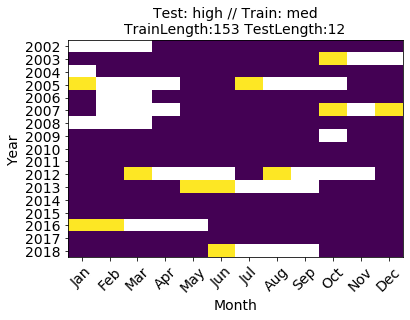

In [165]:
experiment = experiments[11]
# experiment.print_experiment_summary()
experiment.plot_experiment_split()

In [166]:
pred_timesteps = 3
test_timesteps = experiment.test_timesteps

def get_valid_train_timesteps(pred_timesteps: int) -> pd.DatetimeIndex:
    """ENSURE selecting train timesteps NOT including the test timesteps
        as predictor timesteps. I.e. to prevent Data Leakage (train->test)
    """
    all_timesteps = experiment.sorted_timesteps.copy().sort_values()

    dict_ = {
        f'test_{ix}': bool_arr
        for ix, bool_arr in enumerate([all_timesteps == t for t in experiment.test_timesteps])
    }
    df = pd.DataFrame(dict_)

    # get the index values for the TEST months + pred_timesteps
    # because these timesteps cannot be seen by the TRAIN data 
    # to prevent model leakage
    list_of_invalid_indexes = [
        [i for i in range(df.index[df[col]][0], (df.index[df[col]] + (pred_timesteps + 1))[0])]
        for col in df.columns
    ]

    list_of_invalid_indexes = np.array(list_of_invalid_indexes).flatten()
    bool_invalid_list = [True if i not in list_of_invalid_indexes else False for i, ts in enumerate(all_timesteps)]
    valid_train_timesteps = all_timesteps[bool_invalid_list]

    return valid_train_timesteps

valid_train_timesteps = get_valid_train_timesteps(3)
valid_train_timesteps

DatetimeIndex(['2002-04-30', '2002-05-31', '2002-06-30', '2002-07-31',
               '2002-08-31', '2002-09-30', '2002-10-31', '2002-11-30',
               '2002-12-31', '2003-01-31',
               ...
               '2017-11-30', '2017-12-31', '2018-01-31', '2018-02-28',
               '2018-03-31', '2018-04-30', '2018-05-31', '2018-10-31',
               '2018-11-30', '2018-12-31'],
              dtype='datetime64[ns]', name='time', length=161, freq=None)

In [167]:
from scripts.utils import get_data_path

def rename_experiment_dir(
    data_dir: Path,
    train_hilo: str,
    test_hilo: str,
    train_length: int,
    dir_: str = "models",
) -> Path:
    from_path = data_dir / dir_ / "one_month_forecast"

    to_path = (
        data_dir
        / dir_
        / f"one_month_forecast_TR{train_hilo}_TE{test_hilo}_LEN{train_length}"
    )

    # with_datetime ensures that unique (OFF)
    _rename_directory(from_path, to_path, with_datetime=False)
    
    return to_path


def run_experiments(vars_to_exclude: List, pred_months: int = 3, target_var = 'boku_VCI'):
    expected_length = pred_months

    # 1. Read the target data
    print(f"** Reading the target data for {target_var}**")
    data_dir = get_data_path()

    if target_var == 'VCI':
        target_data = xr.open_dataset(
            data_dir / "interim" / "VCI_preprocessed" / "data_kenya.nc"
        )

    if target_var == 'boku_VCI':
        target_data = xr.open_dataset(
            data_dir / "interim" / "boku_ndvi_1000_preprocessed" / "data_kenya.nc"
        )

    target_data = target_data[[target_var]]
    
    # 2. Sort the target data by MEDIAN MONTH values
    sorted_df, sorted_timesteps = sort_by_median_target_var(target_data, pred_months)

    # 3. create all experiments
    # train_hilo(9), test_hilo(3), train_length(1)
    print("** Creating all experiments **")
    hilos = ["high", "med", "low"]
    
    # calculate the length of the test timesteps
    test_length = 12
    total_months = target_data.resample(time='M').mean().time.shape[0]
    total_train_months = total_months - test_length

    print("N Test Months: ", test_length)
    print("N Train Months: ", total_train_months)
    print("N Train Months in each Experiment: ", calculate_length_of_hi_med_lo_experiment_train_years(total_months, test_length))
    
    experiments = [
        Experiment(
            train_length=train_length, test_length=test_length,
            train_hilo=train_hilo, test_hilo=test_hilo, 
            sorted_timesteps=sorted_timesteps
        )
        for train_hilo, test_hilo, train_length in itertools.product(
            hilos, hilos, train_lengths
        )
    ]

    # 4. Run the experiments
    print("** Running all experiments **")
    for experiment in experiments:
        test_timesteps, train_timesteps = experiment.test_timesteps, experiment.train_timesteps
        
        if DEBUG:
            experiment.print_experiment_summary()
        
        # a. Run the Engineer for these train/test periods
        # TODO:
        assert False, "Need to fix up the engineer to work with specific months too ..."
        engineer = Engineer(
            get_data_path(),
            experiment="one_month_forecast",
            process_static=True,
            different_training_periods=True,
        )
        engineer.engineer_class.engineer(
            test_year=test_timesteps,         # defined by experiment
            train_years=train_timesteps,      # defined by experiment
            pred_months=pred_months,          # 3 by default
            expected_length=expected_length,  # == pred_month by default
            target_variable=target_var,
        )
    
        # b. run the models
        parsimonious()
        lstm(vars_to_exclude, static="features")
        ealstm(vars_to_exclude, static="features")

        # c. save the experiment metadata
        save_object = dict(
            train_hilo=experiment.train_hilo,
            test_hilo=experiment.test_hilo,
            train_length=len(experiment.train_timesteps),
            ignore_vars=ignore_vars,
            static=static,
            train_timesteps=experiment.train_timesteps,
            test_timesteps=experiment.test_timesteps,
            features_path=features_path,
            models_path=models_path,
            sorted_timesteps=experiment.sorted_timesteps
        )
        
        with open(data_dir / "models/one_month_forecast/experiment.json", "wb") as fp:
            json.dump(expt_dict, fp, sort_keys=True, indent=4)
        
        # d. rename the directories (TRAIN/TEST)
        data_dir = get_data_path()
        features_path = rename_experiment_dir(
            data_dir, train_hilo=train_hilo, test_hilo=test_hilo, train_length=train_length,
            dir_='features'
        )
        models_path = rename_experiment_dir(
            data_dir, train_hilo=train_hilo, test_hilo=test_hilo, train_length=train_length,
            dir_='models'
        )
        
        

In [168]:
vars_to_exclude = ['modis_ndvi', 'VCI', 'Eb', 'p84.162', 'sp', 'tp']

run_experiments(vars_to_exclude)

** Reading the target data for boku_VCI**


TypeError: unsupported operand type(s) for /: 'int' and 'str'

In [ ]:
# [v for v in ds.data_vars]

In [170]:
pd.Timestamp

pandas._libs.tslibs.timestamps.Timestamp